# Scraping the Courts and Tribunals Judiciary Website to collect Prevent Future Death (PFD) reports 

In [62]:
from requests import get
from requests import ConnectionError
from bs4 import BeautifulSoup
import re
from time import sleep
from time import time
import csv
import pandas as pd

from tqdm.auto import tqdm
from tqdm.contrib import tzip

import urllib3
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

import concurrent

from time import sleep, time

def get_url(url):
    return BeautifulSoup(get(url, verify = False).content, "html.parser")

def retries(record_url, tries=3):
    for i in range(tries):
        try:
            soup = get_url(record_url)
            return soup
        except (ConnectionError, SSLError):
            sleep(2)
            continue
    raise ConnectionError(f"Exceeded {tries} tries")

# Scraper starts here - last run on Monday, 06 Sept 2021, 9.06 am.

Here we find the number of pages containing PFD reports.

In [2]:
prefix = "https://www.judiciary.uk/subject/prevention-of-future-deaths/"
number_of_pages = int(get_url(prefix) \
                    .find("div", "pagination") \
                    .find_all("li")[-1] \
                    .find("a")["href"] \
                    .split("/")[-2])

In [3]:
def fetch_urls(page):
    soup = retries(prefix+"/page/{}".format(str(page+1)))
    h5s = soup.find_all('h5', {'class': 'entry-title'})
    return [h5.a.get('href') for h5 in h5s]

In [4]:
record_urls = []
with tqdm(total = number_of_pages) as pbar:
    with concurrent.futures.ProcessPoolExecutor(max_workers=16) as executor:
        record_urls = [executor.submit(fetch_urls, i)
                       for i in range(number_of_pages)]
        for future in concurrent.futures.as_completed(record_urls):
            pbar.update(1)
record_urls = [link for links in # flatten the list
                   [urls.result() for urls in record_urls]
                   for link in links]

  0%|          | 0/371 [00:00<?, ?it/s]

Some technical remarks: we make all our web requests here to avoid repeatedly making requests to the judiciary’s website. Since `concurrent` must pickle the object we can’t nicely handle exceptions so just have to check the output of `download_html` later for strings beginning `Error: ` (on the assumption that most pages won’t start `Error: `.)

Only the download part is parallelised, on the assumption that downloads are slow but relatively simple to parallelise, and all other operations are finicky but are fast even on a single thread.

It is envisaged that there should be no need to refresh these cells so as to save time.

In [52]:
def download_html(url, tries=5):
    try:
        for i in range(tries):
            try:
                return get(url)
            except (ConnectionError, SSLError):
                sleep(2)
                continue
    except Exception as e:
        if isinstance(e, ConnectionError):
            return "Error: Connection error"
        else:
            return f"Error: {str(e)}"

In [53]:
with tqdm(total = len(record_urls)) as pbar:
    with concurrent.futures.ProcessPoolExecutor(max_workers=16) as executor:
        raw = [executor.submit(download_html, url) for url in record_urls]
        for future in concurrent.futures.as_completed(raw):
            pbar.update(1)

  0%|          | 0/3708 [00:00<?, ?it/s]

In [197]:
class MissingRecordsError(Exception): pass
class MissingFieldError(Exception): pass
class UnreadableFieldError(Exception): pass
class FieldError(Exception): pass
class SpecialCaseUnaccountedForError(Exception): pass
class TooManyTriesError(Exception): pass
class MissingDownloadBoxError(Exception): pass

special_cases = [
    "https://www.judiciary.uk/publications/roadsafety/",
    "https://www.judiciary.uk/publications/helen-sheath/",
    "https://www.judiciary.uk/publications/rebecca-evans/"
]

columns = list(map(lambda x: x.lower(), [
    'Date of report',
    'Ref',
    'Deceased name',
    'Coroner name',
    'Coroner Area',
    'Coroners Area', #NB to be merged later; if both come up there'll be trouble
    'Category',
    "This report is being sent to"
]))

records, refs, pdflinks = [], [], []

plurals_possessives = re.compile(r"’s\s|s\s|'s\s")

In [200]:
class Extractor(object):
    def __init__(self, raw_with_url):
        try:
            self.url = raw_with_url[0]
            url = self.url
            self.extracted = {"url": url, "errors": []}

            self.result = raw_with_url[1].result()
            
            if isinstance(self.result, str):
                if self.result.startswith("Error:"):
                    raise ConnectionError
            
            self.soup = BeautifulSoup(self.result.content)
            
            self.information_area = self.soup.find("div", {"class": "entry-content"})
            
            if not self.information_area:
                raise MissingRecordsError         
            
            self.information = self.information_area.find_all("p")

            # nothing between <p> to process
            if not self.information:
                raise MissingRecordsError         

            if url in special_cases:
                self._process_special_case(url)
            else:
                 for field in self.information:
                    self.strip_field(field, url)

            download_box = self.soup.find("div", "download-box")
            
            if download_box:
                links = download_box.find_all('a', href=True)
                responses = len([s for s in links if "response" in s.text.lower()])
            else:
                raise MissingDownloadBoxError
                
            pdflinks.append([link.href for link in links])

            self.extracted["number of links"] = len(links)
            self.extracted["number of responses"] = responses

            try:
                self.extracted["number of recipients"] = self.extracted["this report is being sent to"].count(";") + 1
            except:
                pass

            try:
                if self.extracted["ref"] in refs: # deduplication of references
                    self.extracted["ref"] += "-bis"
                refs.append(self.extracted["ref"])
            except KeyError:
                self.extracted["ref"] = "autogenerated-ref" # no reference found

        except Exception as e:
            details = str(e)

            if isinstance(e, ConnectionError):
                details = "Could not connect"

            if isinstance(e, MissingRecordsError):
                details = "No records found"

            if isinstance(e, SpecialCaseUnaccountedForError):
                details = "Special case unaccounted for"
            
            if isinstance(e, MissingFieldError):
                details = f"Missing header: {e}"
            
            if isinstance(e, AttributeError):
                details = f"Attribute error: {e}"
                
            if isinstance(e, MissingDownloadBoxError):
                details = f"Missing download box."

            print(f"At {url}, {details}")
                
            self.extracted["errors"].append({"url": self.url, "reason": details})

    def strip_field(self, field, url):
        try:
            extraction = self.FieldStripper(field, url)
            self.extracted[extraction.header] = extraction.text
            if extraction.error is not None:
                self.extracted["errors"].append(extraction.error)
        except FieldError:
            self.extracted["errors"].append({"url": self.url, "reason": f"Field error: {field}"})
            
    def _process_special_case(self,url):
        if self.url == 'https://www.judiciary.uk/publications/roadsafety/':
            fields = self.information[0].find_all('strong')
            heads = ['date of report',
                     'ref',
                     'deceased name',
                     'coroner name',
                     'coroner area',
                     'category']
            for field, h in zip(fields,heads):
                self.extracted[h] = field.next_sibling.replace(':','').replace('Ref','').strip()
        elif url == 'https://www.judiciary.uk/publications/helen-sheath/':
            fields = self.information[0].text.split('\n')
            vals = [field.split(":") for field in fields]
            for v in vals:
                if v[0] == "Coroners name":
                    alt = "coroner_name"
                elif v[0] == "Coroners Area":
                    alt = "coroner_area"
                else:
                    alt = v[0].strip().lower()
                self.extracted[alt] = v[1].strip().replace('\n','')
        elif url == "https://www.judiciary.uk/publications/rebecca-evans/":
            for field in self.information:
                if "Rebecca-EvansR" in field.text:
                    self.extracted["category"] = field.text.split(':')[1].strip().replace('\n','')
                else:
                    self.strip_field(field, url)

        else:
            raise SpecialCaseUnaccountedForError

            
            
    class FieldStripper(object):
        def __init__(self, field, url):
            try:
                self.error = None
                self.url = url
                self.field_text = field.text.strip()
                self.text = ""

                if self.field_text.replace('\xa0','').strip() == "": raise MissingFieldError

                    
                if ":" in self.field_text:
                    self.pre_colon, self.post_colon = self.field_text.split(":", 1) # split by first colon
                else:
                    self.pre_colon = self.field_text
                    self.post_colon = ""
                
                
                self.header = self.pre_colon.lower()
                
    #             print(self.field_text)
    #             print(self.pre_colon)
    #             print(self.post_colon)
    #             print(self.header)

                if self.header in columns: # Normal case: colon separates text
                    self.text = self.post_colon.strip().replace('\n','').replace('\xa0','')
    #                 print("Normal case")
    #                 print(self.header)
    #                 print(self.text)

                elif self.post_colon.strip() == "": # no colon separator
                    self.header, self.text = self._no_colon_separator()          
    #                 print("No colon case")
    #                 print(self.header)
    #                 print(self.text)
                elif self.field_text.count(":") == 2: # two colons
                    self.header, self.text = self._two_colons()
    #                 print("Two colons case")
    #                 print(self.header)
    #                 print(self.text)
                elif ':' in self.field_text and self.header not in columns: # plurals and possessives
                    self.header, self.text = self._plurals_and_possessives()
                else:
                    print(self.field_text)
                
            except Exception as e:
                details = str(e)

                if isinstance(e, UnreadableFieldError):
                    details = f"Unreadable field; text read: {field.text}"
                    
                if isinstance(e, MissingFieldError):
                    details = f"Unreadable field; text read: {field.text}"
                
                self.error = {"url": self.url, "reason": details}
                
                raise FieldError

        def _no_colon_separator(self):
            column_found = False
            for column in columns:
                if self.pre_colon.startswith(column):
                    header = column
                    text = pre_colon[len(column)+1] \
                            .replace('\n','') \
                            .replace('\xa0','')
                    column_found = True
                    break
            if not column_found:
                raise UnreadableFieldError
            return (header, text)

        def _two_colons(self):
            split_by_colon = self.field_text.split(':')
            header = re.sub(plurals_possessives,
                             ' ',
                             split_by_colon[0]+split_by_colon[1]
                            ) \
                            .strip() \
                            .lower()
            text = split_by_colon[2] \
                        .strip() \
                        .replace('\n','') \
                        .replace('\xa0','')
            return (header, text)

        def _plurals_and_possessives(self):
            if 'Name of' in self.field_text:
                header = self.pre_colon.split(' ')[2] + " name"
                text = self.field_text[-1].strip().replace('\n','').replace('\xa0','')
            else:     
                header = re.sub(plurals_possessives, ' ', self.pre_colon).strip().lower()
                text = self.post_colon.strip().replace('\n','').replace('\xa0','')
            return (header, text)

def page_scrape(raw_with_url):
    scraper = Extractor(raw_with_url)
    return scraper.extracted

Here is the third loop to save the PDFs using the deceased Ref as the file name

In [199]:
records = [page_scrape(page) for page in tzip(record_urls, raw)]
errors = [record["errors"] for record in records if record["errors"] != []]

  0%|          | 0/3708 [00:00<?, ?it/s]

Missing download box.
Missing download box.
No records found
No records found
No records found
No records found
No records found
No records found
No records found
No records found
No records found


In [232]:
df = pd.DataFrame(records)
print("\n".join(sorted(df.columns)))

category
coroner area
coroner name
coroners area
date of report
date of reports
deceased name
deceased names
errors
number of links
number of recipients
number of responses
ref
these report are being sent to
this report is being sent to
url


In [247]:
df["coroner area"] = df["coroner area"].fillna(df["coroners area"])
df["date of report"] = df["date of report"].fillna(df["date of reports"])

In [248]:
areas = df["coroner area"].unique()
print(areas)

['Birmingham and Solihull' 'Greater Manchester South'
 'Leicester City and South Leicestershire' 'City of Brighton and Hove'
 'South Yorkshire East' 'South Yorkshire (East)' 'Surrey'
 'West Yorkshire (East)' 'Suffolk' 'Essex' 'West London' 'East London'
 'North East Kent' 'West Sussex'
 'Stoke-on-Trent and North Staffordshire Coroner’s Court'
 'Inner West London' 'Mid Kent and Medway' 'Norfolk'
 'Stoke-on-Trent & North Staffordshire Coroner’s Court'
 'London Inner South' 'Black Country' 'Staffordshire South'
 'Cambridgeshire and Peterborough' 'Nottinghamshire' 'Northamptonshire'
 'Brighton & Hove' 'Exeter and Greater Devon' 'Inner North London'
 'North Wales (East & Central)' 'County of Dorset' 'City of Sunderland'
 'Swansea and Neath Port Talbot' 'Liverpool and Wirral'
 'West Yorkshire (Eastern)' 'Swansea, Neath & Port Talbot'
 'North Wales (East and Central)' 'Gwent' 'Cambridgeshire & Peterborough'
 'Newcastle Upon Tyne and North Tyneside' 'Avon' 'Lincolnshire'
 'Warwickshire' 'South

<AxesSubplot:>

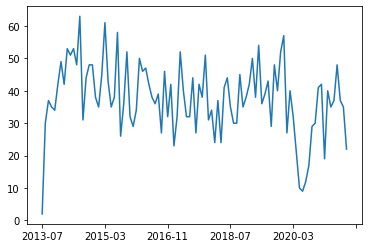

In [271]:
date_counts = pd.to_datetime(df["date of report"], errors = 'coerce').dropna().apply(lambda dmy: dmy.strftime('%Y-%m')).value_counts().sort_index()
date_counts.plot.line()

This is my final step that puts the text data (info on the deceased/case) into a csv file & adds the date it was pulled

In [ ]:
from datetime import date

headers = ['date_of_report', 'date_of_reports', 'ref', 'deceased_name', 'deceased_names', 'coroner_name', 'coroner_area', 'category', 'this_report_is_being_sent_to', 'these_report_are_being_sent_to', 'url']

with open('death_info_{}.csv'.format(date.today()), 'w', newline='', encoding='utf-8') as deaths_csv:
    writer = csv.DictWriter(deaths_csv, fieldnames=headers)
    writer.writeheader()
    for record in record_text:
        if record == {}:
            pass
        else:
            writer.writerow(record)

This is an addition few steps to check what differences there are from the June 2021 records 

Data processing for website 

In [ ]:
sep_names = pd.read_csv('death_info_2021-09-07.csv')
sep_names.head()

In [ ]:
sep_names['deceased_name'] = sep_names['deceased_name'].fillna("")

In [ ]:
sep_names['deceased_name'] = sep_names['deceased_name'].apply(lambda x: ''.join(i[0] for i in x.split()))

In [ ]:
sep_names['deceased_name'] = sep_names['deceased_name'].str.replace('\W', '')

In [ ]:
sep_names.head()

In [ ]:
sep_names.to_csv('death_info_2021-09-07_processed.csv')